## data

### imports

In [1]:
import os
import zipfile
import importlib
import numpy as np
import pandas as pd
from glob import glob
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
os.chdir('/content/drive/MyDrive')
from modules import process_data, network_f, network_architectures
importlib.reload(network_f)

<module 'modules.network_f' from '/content/drive/MyDrive/modules/network_f.py'>

### get data

In [4]:
data_path = '/content/drive/MyDrive/Thesis_Reading'

subjects = glob(data_path + '/*')

In [ ]:
# code to extract zips, ignore if already extracted

for subj in tqdm(subjects):
  zipf_path = glob(subj + '/*.zip')[0]
  dest_path = zipf_path[:-4]

  with zipfile.ZipFile(zipf_path, 'r') as zip_ref:
    zip_ref.extractall(dest_path)

  0%|          | 0/20 [00:00<?, ?it/s]

In [5]:
subj_data = {}


for subj in tqdm(subjects):
  fls = glob(subj + '/*')
  fls = os.listdir(subj)
  subj_id = 'subj_' + subj.split('/')[-1]

  for fl in fls:
    fl_path = f'{subj}/{fl}'
    if fl.endswith('.csv'):
      if fl.startswith('Data'):
        sensor_path = fl_path
      else:
        survey_path = fl_path
    elif os.path.isdir(fl_path):
      hr_path = fl_path

  sensor_data = pd.read_csv(sensor_path)
  channels = ['x_acc', 'y_acc', 'z_acc', 'x_gyro', 'y_gyro', 'z_gyro']
  watch_data = np.stack([sensor_data[ch].values for ch in channels])
  watch_data = {'epoch': sensor_data['epoch'].values, 'values': watch_data}

  survey_data = pd.read_csv(survey_path)
  survey_data = {k:v for k,v in survey_data.items() if 'emo' not in k}
  
  hr_data = pd.read_csv(f'{hr_path}/HR.csv')
  hr_data = process_data.process_hr(hr_data, watch_data['epoch'][-1])

  subj_data[subj_id] = {'watch_data':watch_data, 'survey_data':survey_data, 'hr_data':hr_data}

  0%|          | 0/20 [00:00<?, ?it/s]

### plot watch data

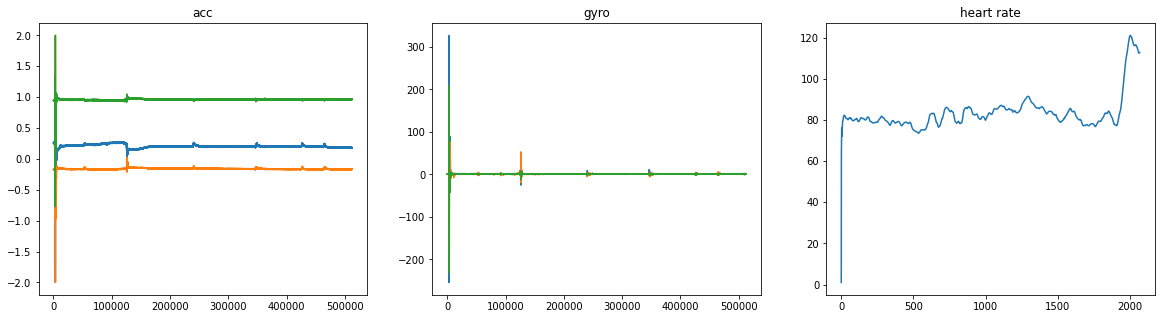

In [6]:
fig, axs = plt.subplots(1,3, figsize=(20,5))

plt.sca(axs[0])
# acc data
plt.plot(subj_data['subj_1']['watch_data']['values'][:3].T)
plt.title('acc')

plt.sca(axs[1])
# gyro data
plt.plot(subj_data['subj_1']['watch_data']['values'][3:].T)
plt.title('gyro')

plt.sca(axs[2])
plt.plot(subj_data['subj_1']['hr_data']['values'])
plt.title('heart rate')

plt.show()

### interpolate

In [7]:
# interpolate watch data to be of same length

watch_data, hr_data = [], []
for subj in subj_data.values():
  watch_data.append(subj['watch_data']['values'])
  hr_data.append([subj['hr_data']['values']])

watch_data = process_data.interpolate(watch_data, 50000, inputs_shape=(20,6,50000))
watch_data, _ = process_data.standard_normal(watch_data, standardize=False)

hr_data = process_data.interpolate(hr_data, 2000, inputs_shape=(20,1,2000))
hr_data, _ = process_data.standard_normal(hr_data, standardize=False)

resizing:   0%|          | 0/20 [00:00<?, ?it/s]

resizing:   0%|          | 0/20 [00:00<?, ?it/s]

### peak detection

In [8]:
acc_max_idx = np.argmax( np.max(abs( subj_data['subj_1']['watch_data']['values'][:3]), 0) )
gyro_max_idx = np.argmax( np.max(abs( subj_data['subj_1']['watch_data']['values'][3:]), 0) )

sensor_max_idx = (acc_max_idx + gyro_max_idx) // 2
print(acc_max_idx, gyro_max_idx, sensor_max_idx)

hr_values = np.array(subj_data['subj_1']['hr_data']['values'])
hr_mean = hr_values.mean()
hr_devia = (hr_values - hr_mean)**2
hr_max_idx = np.argmax(hr_devia)
print(hr_max_idx)

3209 3202 3205
0


## neural network

In [9]:
print(watch_data.shape)
print(hr_data.shape)

(20, 6, 50000)
(20, 1, 2000)


In [10]:
reshaped_watch_data = []
for wd in watch_data:
  x = []
  for i in range(2000):
    x.append(wd[:,i*25 : (i+1)*25].flatten())
  x = np.array(x)
  
  reshaped_watch_data.append(x)

reshaped_watch_data = np.array(reshaped_watch_data)

reshaped_watch_data.shape

(20, 2000, 150)

In [11]:
reshaped_hr_data = hr_data.squeeze()
reshaped_hr_data.shape

(20, 2000)

In [12]:
x = reshaped_watch_data.reshape(-1, 150)
print(x.shape)

x = reshaped_hr_data.reshape(-1,1)
print(x.shape)

(40000, 150)
(40000, 1)


In [13]:
loaders = process_data.createLoaders(reshaped_watch_data.reshape(-1, 150), reshaped_hr_data.reshape(-1,1))

In [14]:
model,criterion,optimizer = network_f.setupModel(network_architectures.Linear_Net())

params: 8071


training model


epoch:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 10  | train loss: 0.0817, val loss: 0.0961,  | avg train loss: 0.0937, avg val loss: 0.0982, 

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 20  | train loss: 0.0751, val loss: 0.0912,  | avg train loss: 0.0779, avg val loss: 0.0921, 

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 30  | train loss: 0.0683, val loss: 0.0932,  | avg train loss: 0.0712, avg val loss: 0.0922, 

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 40  | train loss: 0.0655, val loss: 0.0911,  | avg train loss: 0.0669, avg val loss: 0.0894, 

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 50  | train loss: 0.0625, val loss: 0.0889,  | avg train loss: 0.0640, avg val loss: 0.0898, 

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 60  | train loss: 0.0610, val loss: 0.0936,  | avg train loss: 0.0619, avg val loss: 0.0903, 

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 70  | train loss: 0.0593, val loss: 0.0918,  | avg train loss: 0.0600, avg val loss: 0.0909, 

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 80  | train loss: 0.0582, val loss: 0.0905,  | avg train loss: 0.0585, avg val loss: 0.0921, 

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 90  | train loss: 0.0570, val loss: 0.0939,  | avg train loss: 0.0574, avg val loss: 0.0918, 

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch: 100  | train loss: 0.0561, val loss: 0.0921,  | avg train loss: 0.0563, avg val loss: 0.0929, Finished Training


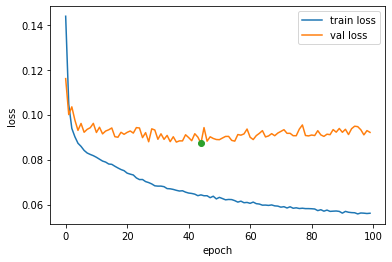

In [15]:
best_params, last_params = network_f.train_model(model, criterion, optimizer, loaders, epochs=100)